In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from xgboost import XGBClassifier

# Evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('tesla_stock_data.csv')
df.head()

,Date,Sentiment,Open,High,Low,Close,Volume,RSI_14,SMA_20,EMA_20
0,2013-01-29,0.505748,2.540000,2.562667,2.475333,2.530000,21399000,73.639417,2.326000,2.326000
1,2013-01-30,0.505748,2.523333,2.533333,2.495333,2.501333,14521500,68.913398,2.338167,2.342698
2,2013-01-31,0.505748,2.524667,2.524667,2.462000,2.500667,13521000,68.802937,2.345333,2.357743
3,2013-02-01,0.505748,2.544667,2.566667,2.508000,2.553333,16509000,72.550435,2.357100,2.376371
4,2013-02-04,0.503098,2.560000,2.561333,2.506000,2.516000,16920000,66.456306,2.368233,2.389669


# Visualizing the stock price

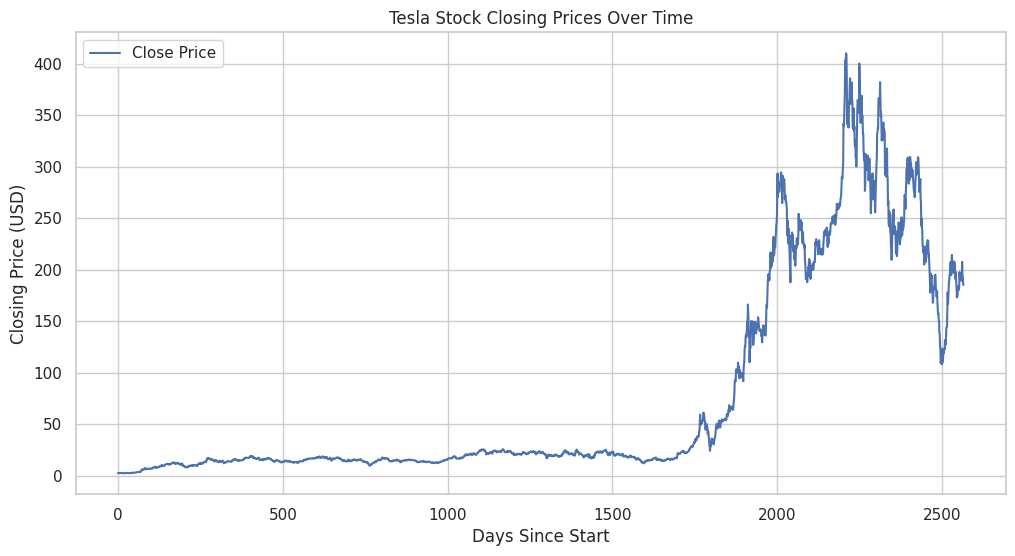

In [ ]:
date_range = range(len(df['Date']))

plt.figure(figsize=(12,6))

sns.lineplot(x=date_range, y=df['Close'], label='Close Price')

plt.title('Tesla Stock Closing Prices Over Time')
plt.xlabel('Days Since Start')
plt.ylabel('Closing Price (USD)')
plt.legend()

plt.show()

# Feature Engineering

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

# Time Features
df['Day_Of_Week'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day_Of_Month'] = df['Date'].dt.day
df['Is_Month_Start'] = df['Date'].dt.is_month_start.astype(int)
df['Is_Month_End'] = df['Date'].dt.is_month_end.astype(int)
df['Is_Weakend'] = df['Date'].dt.weekday >= 5
df['Week_Of_Year'] = df['Date'].dt.isocalendar().week
df['Quarter'] = df['Date'].dt.quarter

# Lagged Price
df['Close_Lag_1'] = df['Close'].shift(1) # Previous day's closing price
df['Close_Lag_2'] = df['Close'].shift(7) # 7-day lag
df['Close_Lag_3'] = df['Close'].shift(14) # 14-day lag

# Returns
df['Log_Return_Lag_1'] = np.log(df['Close'] / df['Close'].shift(1))
df['Log_Return_Lag_7'] = np.log(df['Close'] / df['Close'].shift(7))
df['Log_Return_Lag_14'] = np.log(df['Close'] / df['Close'].shift(14))

df['Percent_Return'] = df['Close'].pct_change()


# Technical Features
df['SMA_5'] = df['Close'].rolling(window=5).mean()
df['SMA_10'] = df['Close'].rolling(window=10).mean()
df['SMA_20'] = df['Close'].rolling(window=20).mean()
df['SMA_50'] = df['Close'].rolling(window=50).mean()
df['SMA_100'] = df['Close'].rolling(window=100).mean()
df['SMA_200'] = df['Close'].rolling(window=200).mean()

df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
df['EMA_10'] = df['Close'].ewm(span=10, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()
df['EMA_100'] = df['Close'].ewm(span=100, adjust=False).mean()
df['EMA_200'] = df['Close'].ewm(span=200, adjust=False).mean()


df['Volatility'] = df['Log_Return_Lag_1'].rolling(window=14).std()
df['Return_MA_5'] = df['Log_Return_Lag_1'].rolling(window=5).mean()
df['Return_MA_10'] = df['Log_Return_Lag_1'].rolling(window=10).mean()


df['VMA_50'] = df['Volume'].rolling(window=50).mean()

# Target Feature
df['Trend_Next_Day'] = np.where(df['Close'].shift(-1) > df['Close'], 1, 0)
df['Trend_Next_3_Days'] = np.where(df['Close'].shift(-3) > df['Close'], 1, 0)
df['Trend_Next_7_Days'] = np.where(df['Close'].shift(-7) > df['Close'], 1, 0)
df['Trend_Next_14_Days'] = np.where(df['Close'].shift(-14) > df['Close'], 1, 0)
df['Trend_Next_30_Days'] = np.where(df['Close'].shift(-30) > df['Close'], 1, 0)


In [ ]:
def compute_rsi(series, period=14):
    delta = series.diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

def compute_macd(series, short_period=12, long_period=26, signal_period=9):
    short_ema = series.ewm(span=short_period, adjust=False).mean()
    long_ema = series.ewm(span=long_period, adjust=False).mean()
    macd = short_ema - long_ema
    signal = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal

def compute_bollinger_bands(series, window=20, num_std=2):
    sma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    upper_band = sma + (std * num_std)
    lower_band = sma - (std * num_std)
    return upper_band, lower_band

def compute_atr(df, window=14):
    high_low = df['High'] - df['Low']

    high_close = np.abs(df['High'] - df['Close'].shift(1))
    low_close = np.abs(df['Low'] - df['Close'].shift(1))

    tr = pd.concat([high_low, high_close, low_close], axis=1)
    atr = tr.max(axis=1).rolling(window=window).mean()

    return atr

df['RSI_14'] = compute_rsi(df['Close'], period=14)
df['MACD'], df['MACD_Signal'] = compute_macd(df['Close'])
df['Bollinger_Upper'], df['Bollinger_Lower'] = compute_bollinger_bands(df['Close'])
df['ATR_14'] = compute_atr(df, window=14)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decompostion = seasonal_decompose(df['Close'], model='multiplicative', period=30)
df['Trend'] = decompostion.trend
df['Seasonality'] = decompostion.seasonal
df['Residual'] = decompostion.resid

# Data Report

In [ ]:
!pip -q install ydata_profiling

In [ ]:
from ydata_profiling import ProfileReport

profile = ProfileReport(df, title="Tesla Stock Data Profiling Report", explorative=True)
profile.to_file("tesla_stock_data_profiling_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 53/53 [00:00<00:00, 55.13it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Preprocessing the Data

In [ ]:
# Identify categorical and numerical features

numeric_features = [
    'Open', 'High', 'Low', 'Close', 'Volume', 'RSI_14', 'SMA_20', 'EMA_20',
    'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Log_Return_Lag_1', 'Log_Return_Lag_7',
    'Log_Return_Lag_14', 'Percent_Return', 'SMA_5', 'SMA_10', 'SMA_50', 'SMA_100',
    'SMA_200', 'EMA_5', 'EMA_10', 'EMA_50', 'EMA_100', 'EMA_200', 'Volatility',
    'Return_MA_5', 'Return_MA_10', 'VMA_50', 'ATR_14', 'MACD', 'MACD_Signal',
    'Bollinger_Upper', 'Bollinger_Lower', 'Trend', 'Seasonality', 'Residual',
    'Sentiment'
]

categorical_features = [
    'Day_Of_Week', 'Month', 'Year', 'Day_Of_Month', 'Is_Month_Start',
    'Is_Month_End', 'Is_Weakend', 'Week_Of_Year', 'Quarter'
]

target_feature = ['Trend_Next_Day', 'Trend_Next_3_Days', 'Trend_Next_7_Days', 'Trend_Next_14_Days', 'Trend_Next_30_Days']

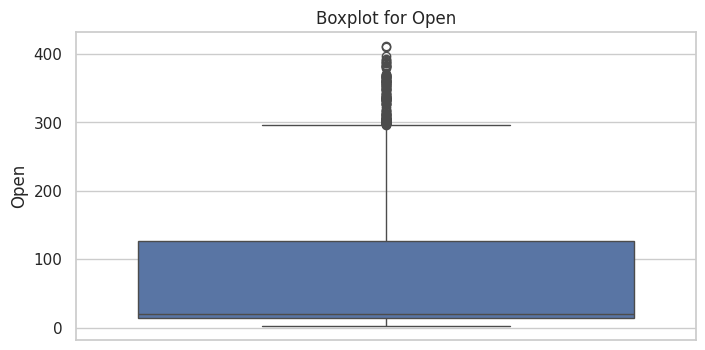

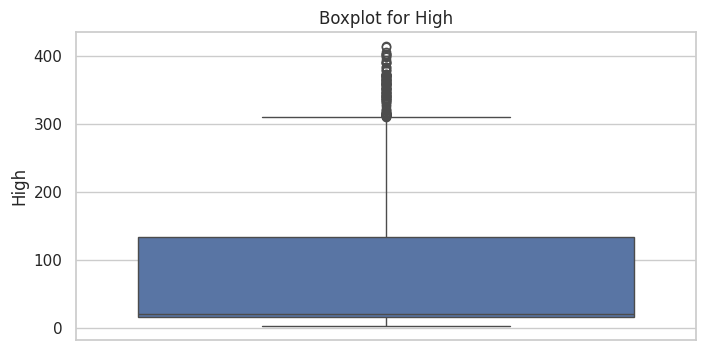

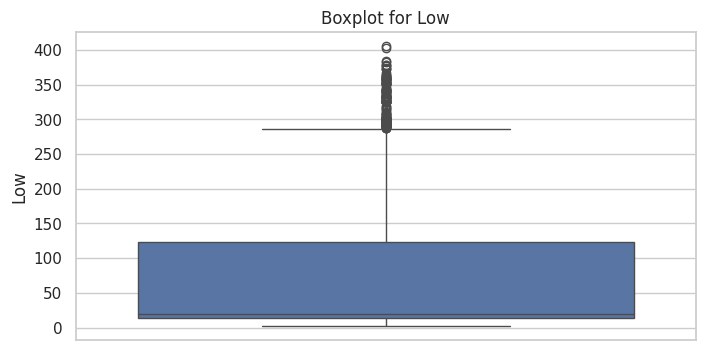

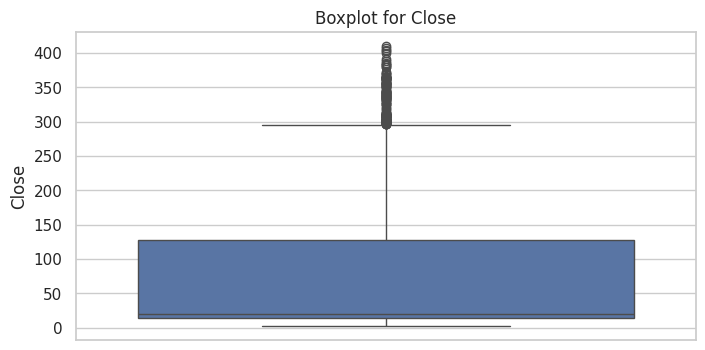

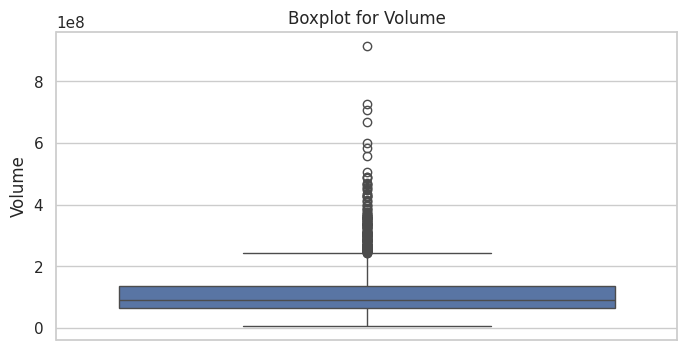

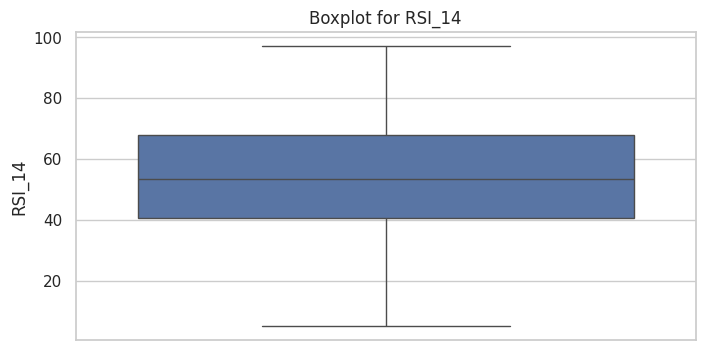

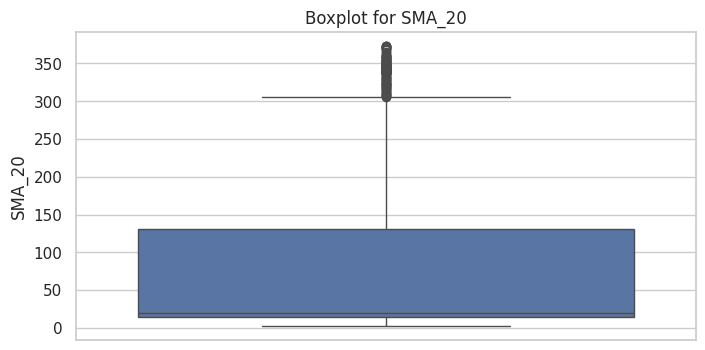

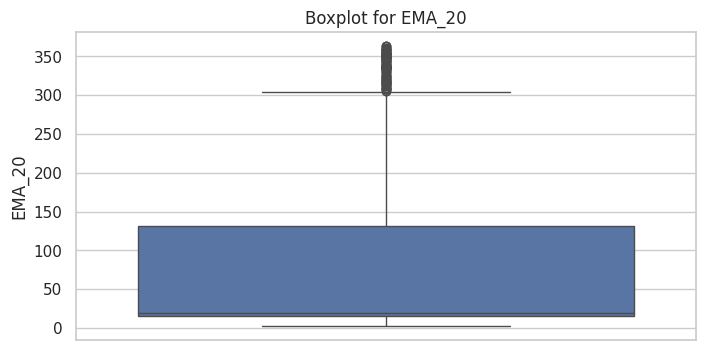

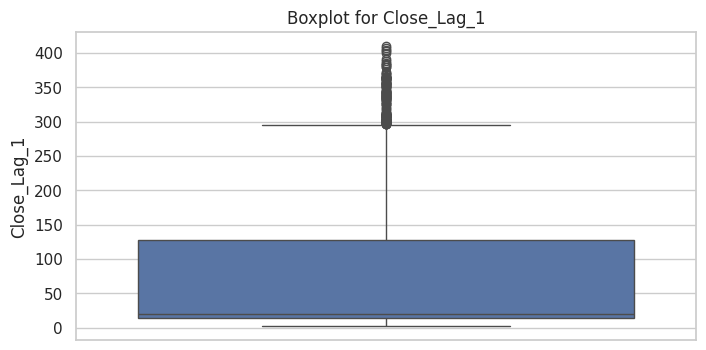

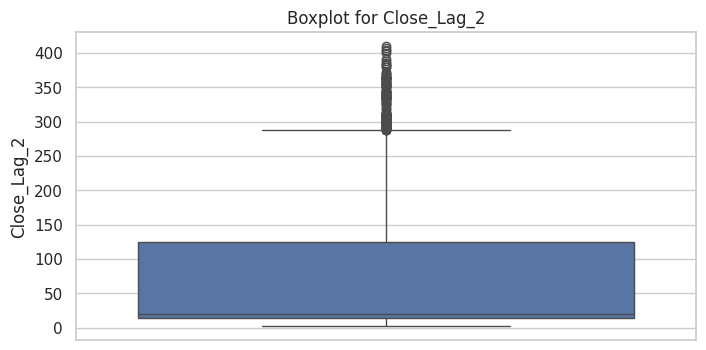

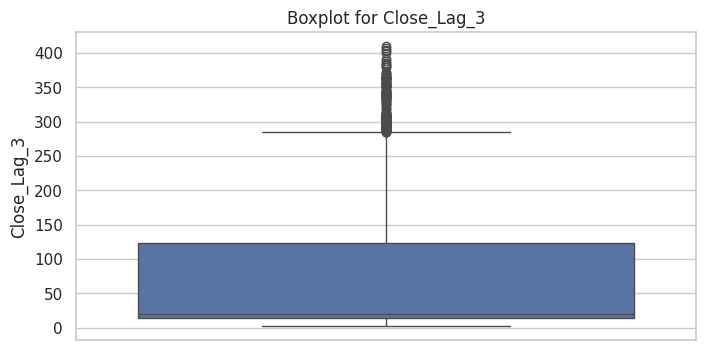

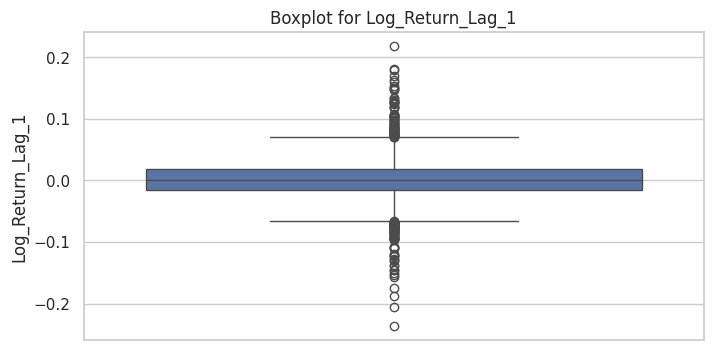

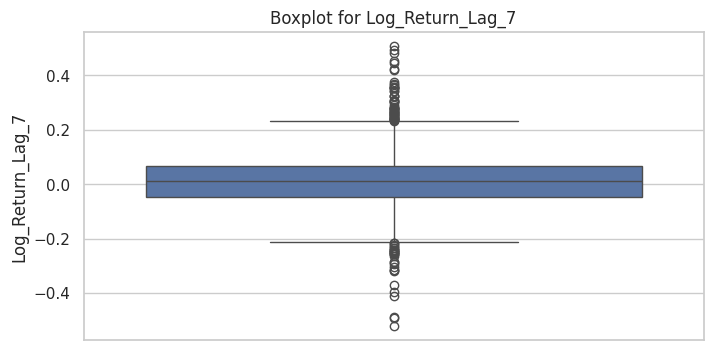

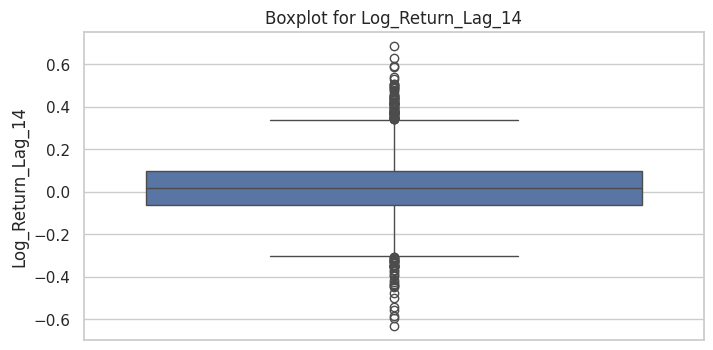

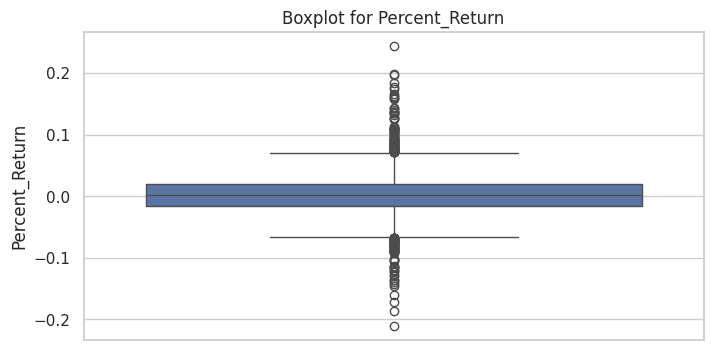

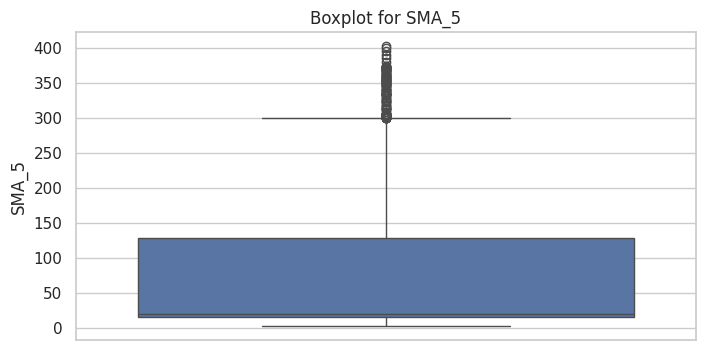

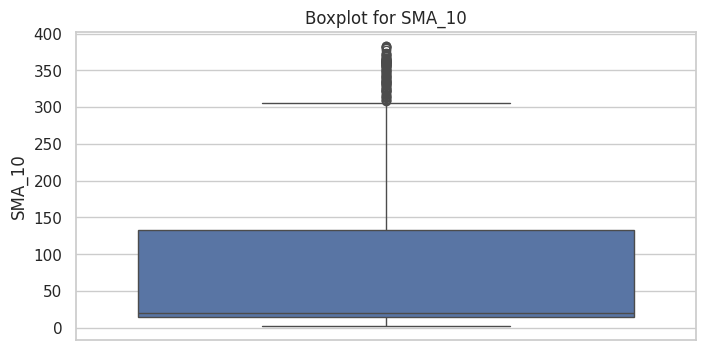

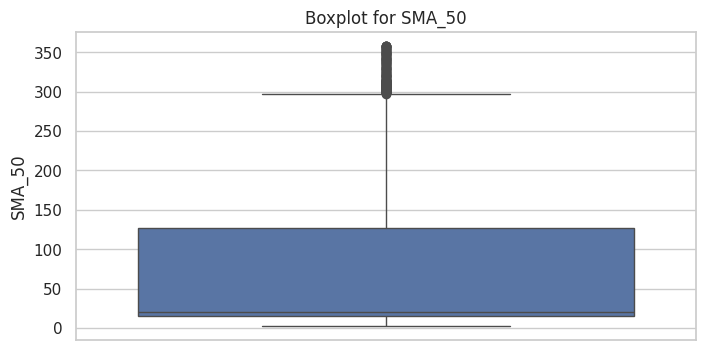

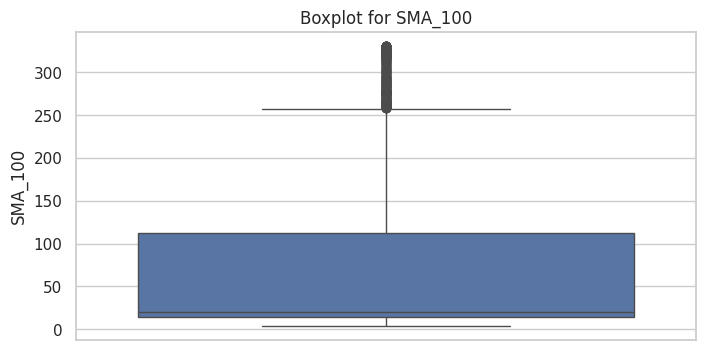

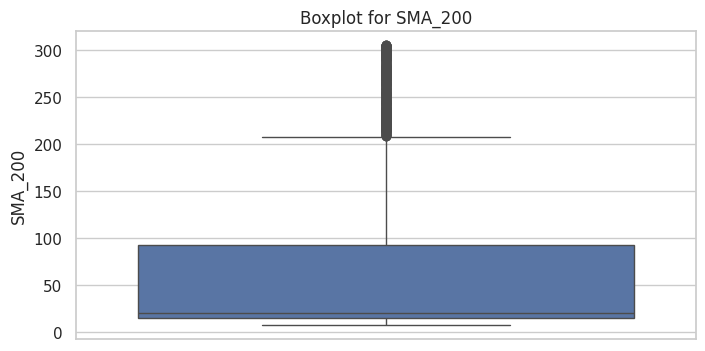

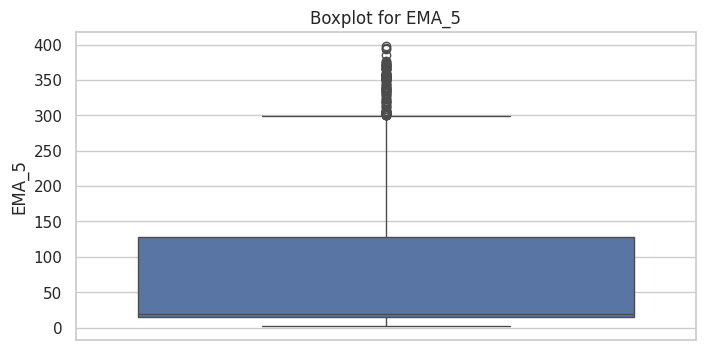

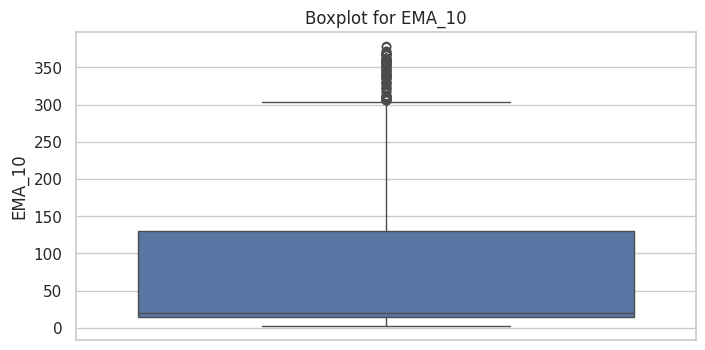

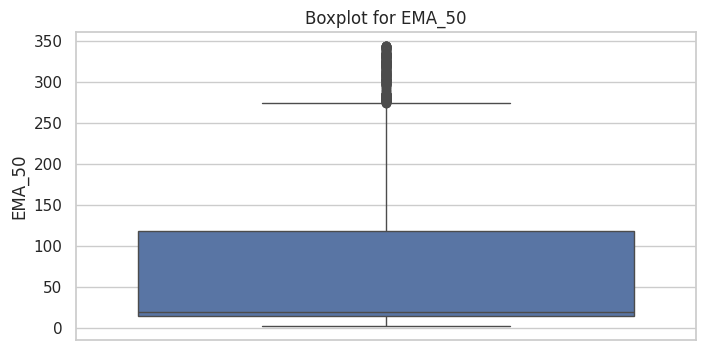

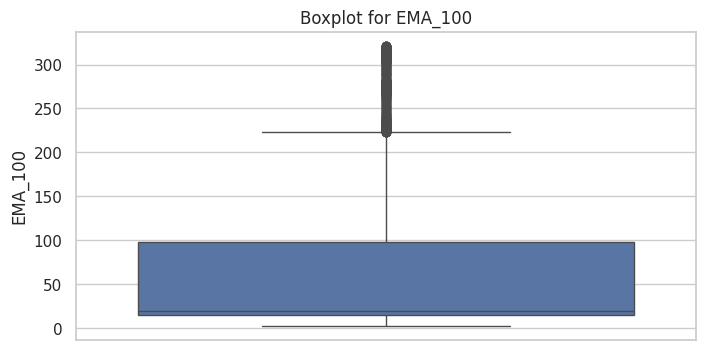

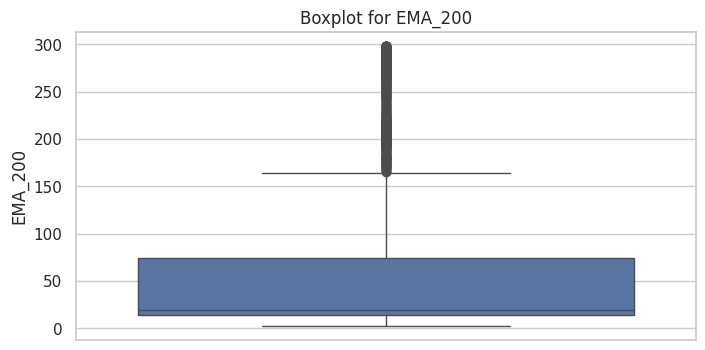

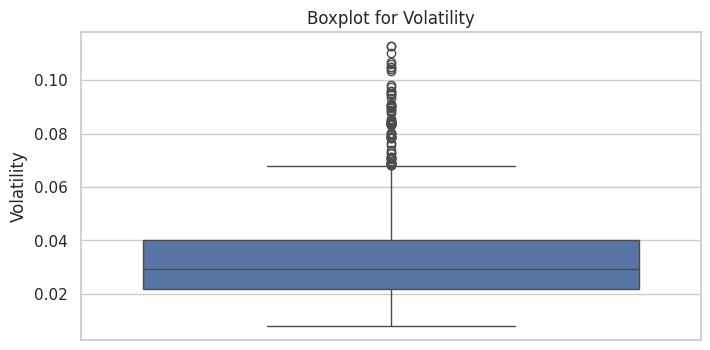

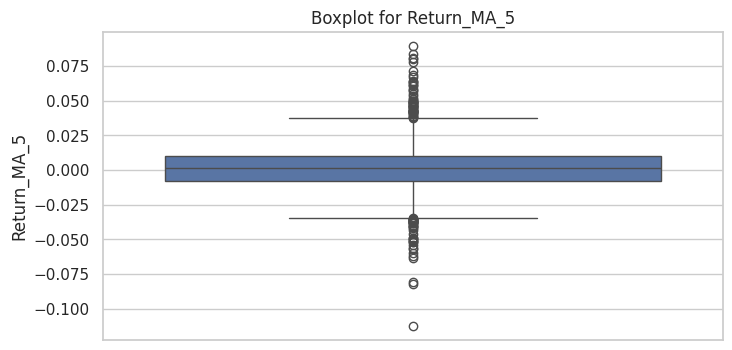

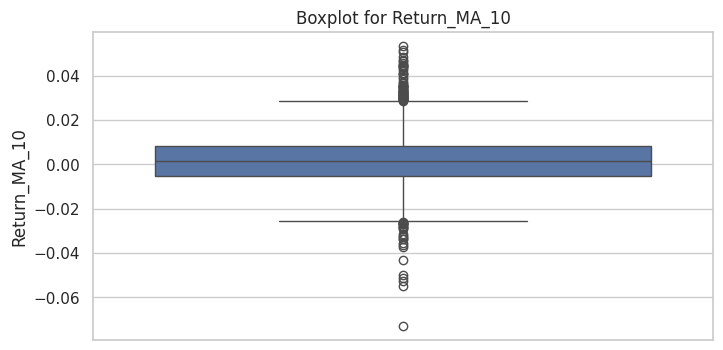

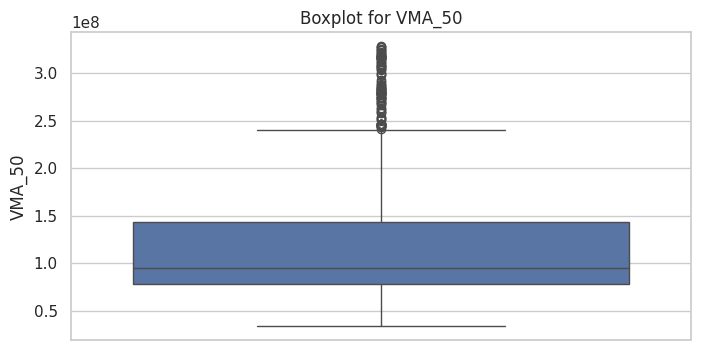

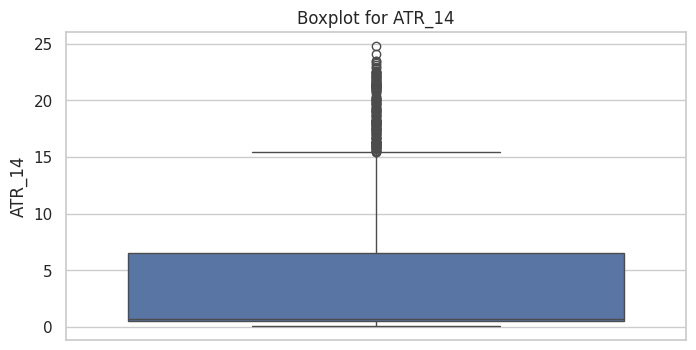

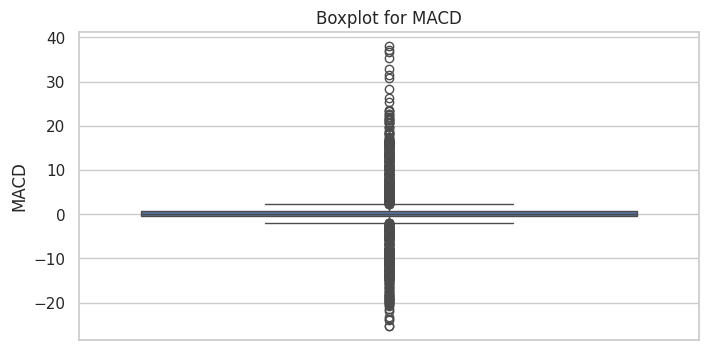

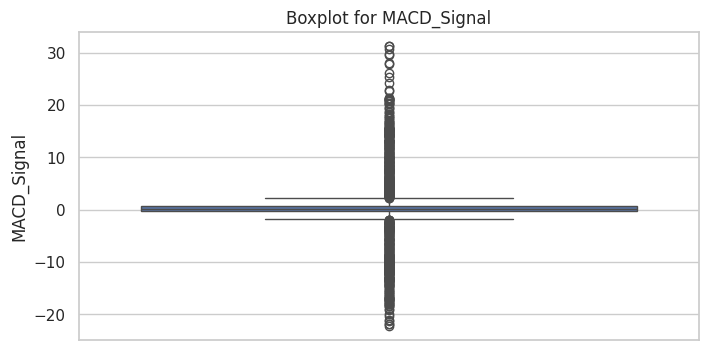

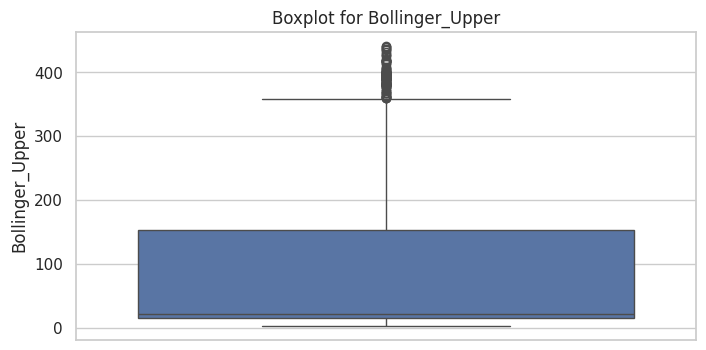

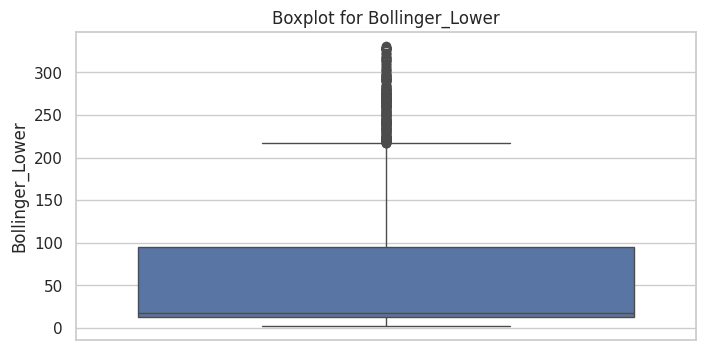

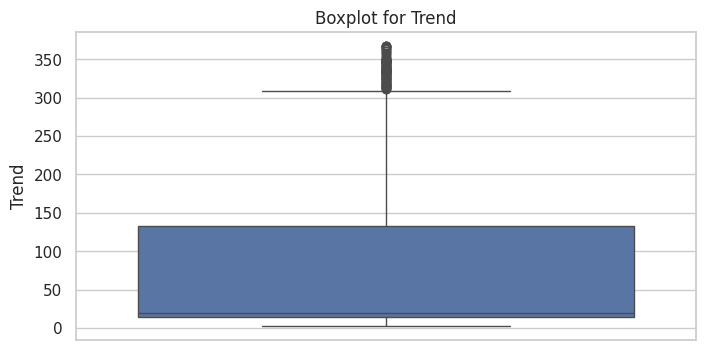

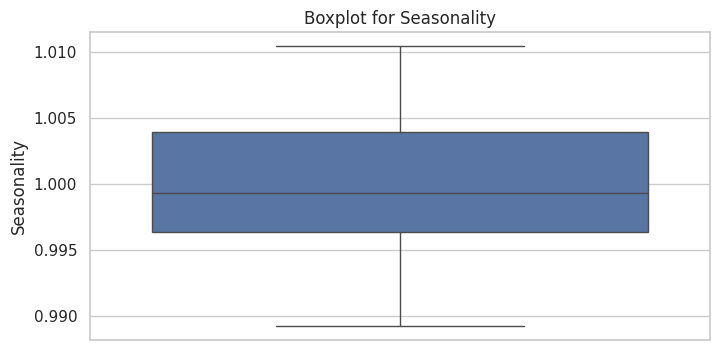

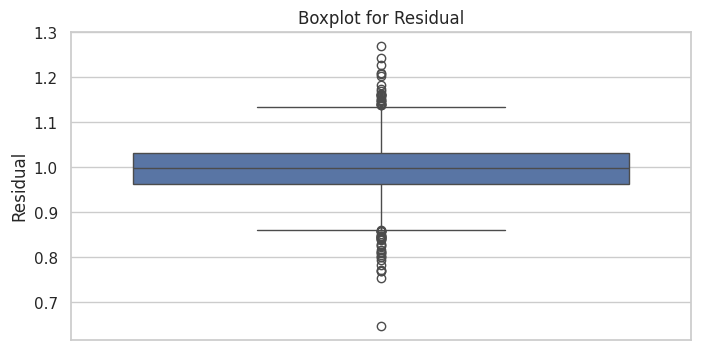

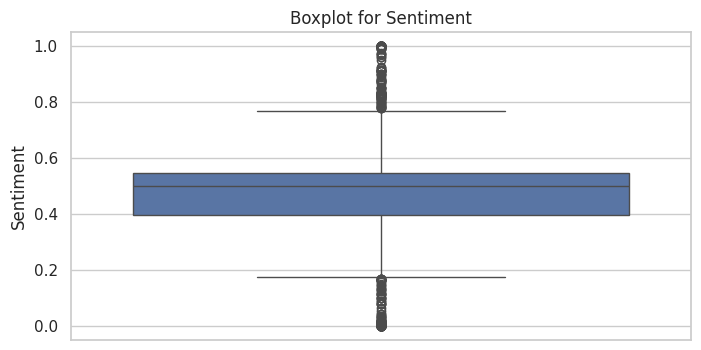

In [ ]:
# Outlier Detection

for numeric_feature in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.boxplot(y=df[numeric_feature])
    plt.title(f'Boxplot for {numeric_feature}')
    plt.show()



In [ ]:
# Splitting the data
X = df.drop(target_feature, axis=1)
X.head()

,Date,Sentiment,Open,High,Low,Close,Volume,RSI_14,SMA_20,EMA_20,...,Return_MA_10,VMA_50,MACD,MACD_Signal,Bollinger_Upper,Bollinger_Lower,ATR_14,Trend,Seasonality,Residual
0,2013-01-29,0.505748,2.540000,2.562667,2.475333,2.530000,21399000,NaN,NaN,2.530000,...,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,1.010433,NaN
1,2013-01-30,0.505748,2.523333,2.533333,2.495333,2.501333,14521500,NaN,NaN,2.527270,...,NaN,NaN,-0.002287,-0.000457,NaN,NaN,NaN,NaN,1.007363,NaN
2,2013-01-31,0.505748,2.524667,2.524667,2.462000,2.500667,13521000,NaN,NaN,2.524736,...,NaN,NaN,-0.004106,-0.001187,NaN,NaN,NaN,NaN,1.003647,NaN
3,2013-02-01,0.505748,2.544667,2.566667,2.508000,2.553333,16509000,NaN,NaN,2.527460,...,NaN,NaN,-0.001282,-0.001206,NaN,NaN,NaN,NaN,1.000785,NaN
4,2013-02-04,0.503098,2.560000,2.561333,2.506000,2.516000,16920000,NaN,NaN,2.526368,...,NaN,NaN,-0.002034,-0.001372,NaN,NaN,NaN,NaN,0.995364,NaN


In [ ]:
# Splitting the data into training and testing sets
train_size = int(0.8 * len(X))

X_train = X.iloc[:train_size]
X_test = X.iloc[train_size:]

y_train = df[target_feature].iloc[:train_size]
y_test = df[target_feature].iloc[train_size:]

In [ ]:
# Numerical Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])

# Categorical Pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [ ]:
# Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Model Selection

In [ ]:
# Base learners
clf_logreg = LogisticRegression(random_state=42, n_jobs=-1)
clf_svc = SVC(random_state=42)
clf_dt = DecisionTreeClassifier(random_state=42)
clf_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
clf_gb = GradientBoostingClassifier(random_state=42)
clf_xgb = XGBClassifier(random_state=42, n_jobs=-1)

stacking_clf = StackingClassifier(
    estimators=[
        ('svc', clf_svc),
        ('rf', clf_rf),
        ('xgb', clf_xgb)
    ],
    final_estimator=LogisticRegression(),
    n_jobs=-1
)

voting_clf = VotingClassifier(
    estimators=[
        ('svc', clf_svc),
        ('rf', clf_rf),
        ('xgb', clf_xgb)
    ],
    voting='hard',
    weights=[1, 1, 1],
    n_jobs=-1
)

In [ ]:
# Models Dictionary
models = {
    'Logistic Regression': clf_logreg,
    'Support Vector Machine': clf_svc,
    'Decision Tree': clf_dt,
    'Random Forest': clf_rf,
    'Gradient Boosting': clf_gb,
    'XGBoost': clf_xgb,
    'StackingClassifier': stacking_clf,
    'VotingClassifier': voting_clf
}


In [ ]:
# Time Series Cross-Validation
tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
model_report = {}

for model_name, model in models.items():
    for target in target_feature:
        # Create Pipeline
        clf_pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])

        # Fit the model
        clf_pipeline.fit(X_train, y_train[target])

        # Cross-Validation
        cv_scores = cross_val_score(clf_pipeline, X_train, y_train[target], cv=tscv, scoring='accuracy', n_jobs=-1)
        cv_mean = cv_scores.mean()
        cv_std = cv_scores.std()

        # Predict
        y_pred = clf_pipeline.predict(X_test)

        # Evaluate
        accuracy = accuracy_score(y_test[target], y_pred)
        precision = precision_score(y_test[target], y_pred)
        recall = recall_score(y_test[target], y_pred)
        f1 = f1_score(y_test[target], y_pred)
        roc_auc = roc_auc_score(y_test[target], y_pred)

        if target not in model_report:
          model_report[target] = []

        model_report[target].append({
            'Model': model_name,
            'CV Mean': cv_mean,
            'CV Std': cv_std,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'ROC-AUC': roc_auc
        })



In [ ]:
best_model_details = {}

for target in target_feature:
  print(f'Target: {target}')

  report_df = pd.DataFrame(model_report[target]).sort_values(by='Accuracy', ascending=False)
  display(report_df)
  print(f'\n')

  best_model_details[target] = report_df.iloc[0]

Target: Trend_Next_Day


,Model,CV Mean,CV Std,Accuracy,Precision,Recall,F1-Score,ROC-AUC
5,XGBoost,0.554256,0.024726,0.583658,0.655367,0.431227,0.520179,0.591124
4,Gradient Boosting,0.525016,0.017532,0.575875,0.642458,0.427509,0.513393,0.583142
2,Decision Tree,0.520468,0.020874,0.542802,0.568000,0.527881,0.547206,0.543532
7,VotingClassifier,0.555556,0.017216,0.529183,0.636364,0.234201,0.342391,0.543631
3,Random Forest,0.515270,0.017459,0.513619,0.604396,0.204461,0.305556,0.528761
0,Logistic Regression,0.545159,0.032709,0.496109,0.666667,0.074349,0.133779,0.516767
6,StackingClassifier,0.517869,0.023945,0.494163,0.542056,0.215613,0.308511,0.507807
1,Support Vector Machine,0.546459,0.020527,0.472763,0.495192,0.382900,0.431866,0.477164




Target: Trend_Next_3_Days


,Model,CV Mean,CV Std,Accuracy,Precision,Recall,F1-Score,ROC-AUC
4,Gradient Boosting,0.656920,0.014325,0.710117,0.744681,0.662879,0.701403,0.711439
5,XGBoost,0.645224,0.024811,0.708171,0.711111,0.727273,0.719101,0.707636
0,Logistic Regression,0.666017,0.017604,0.645914,0.658915,0.643939,0.651341,0.645970
2,Decision Tree,0.539311,0.051163,0.616732,0.616725,0.670455,0.642468,0.615227
7,VotingClassifier,0.608837,0.063352,0.570039,0.617486,0.428030,0.505593,0.574015
6,StackingClassifier,0.578298,0.073977,0.564202,0.635135,0.356061,0.456311,0.570030
3,Random Forest,0.525016,0.041270,0.554475,0.640000,0.303030,0.411311,0.561515
1,Support Vector Machine,0.582196,0.034223,0.435798,0.449219,0.435606,0.442308,0.435803




Target: Trend_Next_7_Days


,Model,CV Mean,CV Std,Accuracy,Precision,Recall,F1-Score,ROC-AUC
6,StackingClassifier,0.740741,0.033537,0.836576,0.865471,0.781377,0.821277,0.834508
5,XGBoost,0.795322,0.008422,0.836576,0.832653,0.825911,0.829268,0.836176
4,Gradient Boosting,0.757635,0.054309,0.824903,0.791822,0.862348,0.825581,0.826305
2,Decision Tree,0.564003,0.065340,0.682879,0.721053,0.554656,0.627002,0.678077
7,VotingClassifier,0.740091,0.055005,0.583658,0.670103,0.263158,0.377907,0.571654
3,Random Forest,0.543860,0.043267,0.568093,0.640449,0.230769,0.339286,0.555460
1,Support Vector Machine,0.640026,0.062507,0.536965,0.544554,0.222672,0.316092,0.525194
0,Logistic Regression,0.761533,0.020153,0.527237,0.583333,0.056680,0.103321,0.509613




Target: Trend_Next_14_Days


,Model,CV Mean,CV Std,Accuracy,Precision,Recall,F1-Score,ROC-AUC
4,Gradient Boosting,0.661468,0.102091,0.830739,0.809160,0.851406,0.829746,0.831363
5,XGBoost,0.751787,0.036096,0.811284,0.792308,0.827309,0.809430,0.811768
2,Decision Tree,0.644574,0.054612,0.704280,0.696356,0.690763,0.693548,0.703872
7,VotingClassifier,0.686160,0.052979,0.655642,0.604651,0.835341,0.701518,0.661067
0,Logistic Regression,0.627031,0.009189,0.649805,0.583942,0.963855,0.727273,0.659286
3,Random Forest,0.543210,0.059814,0.612840,0.595420,0.626506,0.610568,0.613253
6,StackingClassifier,0.643925,0.096556,0.573930,0.536946,0.875502,0.665649,0.583034
1,Support Vector Machine,0.598441,0.078765,0.441634,0.461224,0.907631,0.611637,0.455702




Target: Trend_Next_30_Days


,Model,CV Mean,CV Std,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Logistic Regression,0.471085,0.085834,0.630350,0.673333,0.417355,0.515306,0.618604
5,XGBoost,0.487979,0.125246,0.626459,0.573964,0.801653,0.668966,0.636121
4,Gradient Boosting,0.634828,0.041208,0.620623,0.582456,0.685950,0.629981,0.624225
2,Decision Tree,0.489929,0.126704,0.603113,0.573643,0.611570,0.592000,0.603579
3,Random Forest,0.487979,0.156677,0.591440,0.558394,0.632231,0.593023,0.593689
7,VotingClassifier,0.482781,0.115239,0.566148,0.526761,0.772727,0.626466,0.577540
6,StackingClassifier,0.589344,0.095182,0.439689,0.450216,0.859504,0.590909,0.462840
1,Support Vector Machine,0.539961,0.029819,0.424125,0.443750,0.880165,0.590028,0.449274


In [ ]:
rows = []

for target, details in best_model_details.items():
    row = {"Target": target}
    row.update(details)
    rows.append(row)

best_model_df = pd.DataFrame(rows)
display(best_model_df)


,Target,Model,CV Mean,CV Std,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Trend_Next_Day,XGBoost,0.554256,0.024726,0.583658,0.655367,0.431227,0.520179,0.591124
1,Trend_Next_3_Days,Gradient Boosting,0.656920,0.014325,0.710117,0.744681,0.662879,0.701403,0.711439
2,Trend_Next_7_Days,StackingClassifier,0.740741,0.033537,0.836576,0.865471,0.781377,0.821277,0.834508
3,Trend_Next_14_Days,Gradient Boosting,0.661468,0.102091,0.830739,0.809160,0.851406,0.829746,0.831363
4,Trend_Next_30_Days,Logistic Regression,0.471085,0.085834,0.630350,0.673333,0.417355,0.515306,0.618604


# Tuning Our Selected Models

In [ ]:
from scipy.stats import randint

param = {
    'Logistic Regression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['liblinear']
    },

    'Support Vector Machine': {
        'classifier__C': [1, 10],
        'classifier__kernel': ['linear']
    },

    'Decision Tree': {
        'classifier__max_depth': [3, 7, None],
        'classifier__min_samples_split': randint(2, 8),
        'classifier__min_samples_leaf': randint(1, 6),
        'classifier__max_features': ['sqrt']
    },

    'Random Forest': {
        'classifier__n_estimators': randint(100, 500),
        'classifier__max_depth': [10, None],
        'classifier__min_samples_split': randint(2, 8),
        'classifier__min_samples_leaf': randint(1, 6),
        'classifier__max_features': ['sqrt']
    },

    'Gradient Boosting': {
        'classifier__n_estimators': randint(100, 500),
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [3, 5],
        'classifier__subsample': [0.9, 1.0]
    },

    'XGBoost': {
        'classifier__n_estimators': randint(100, 500),
        'classifier__learning_rate': [0.05, 0.1],
        'classifier__max_depth': [3, 5],
        'classifier__subsample': [0.9, 1.0],
        'classifier__colsample_bytree': [0.8, 1.0]
    },

    'StackingClassifier': {
        'classifier__final_estimator__C': [0.1, 1],
        'classifier__final_estimator__penalty': ['l2']
    },

    'VotingClassifier': {
        'classifier__voting': ['hard'],
        'classifier__weights': [[1, 1, 1], [2, 1, 1]]
    }
}


In [ ]:
model_report_tuned = {}


for target, details in best_model_details.items():
  best_model_name = details['Model']
  model_param = param[best_model_name]

  # Create Pipeline
  clf_pipeline = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('classifier', models[best_model_name])
  ])

  # Hyperparameter Tuning
  randomized_search = RandomizedSearchCV(
      clf_pipeline,
      model_param,
      cv=tscv,
      n_iter=3,
      scoring='accuracy',
      random_state=42,
      n_jobs=-1
  )

  randomized_search.fit(X_train, y_train[target])

  # Get the best model
  best_model = randomized_search.best_estimator_

  # Predict
  y_pred = best_model.predict(X_test)

  # Evaluatation metrics
  accuracy = accuracy_score(y_test[target], y_pred)
  precision = precision_score(y_test[target], y_pred)
  recall = recall_score(y_test[target], y_pred)
  f1 = f1_score(y_test[target], y_pred)
  roc_auc = roc_auc_score(y_test[target], y_pred)

  if target not in model_report_tuned:
    model_report_tuned[target] = []

  model_report_tuned[target].append({
      'Model': best_model_name,
      'Best Params': randomized_search.best_params_,
      'Accuracy': accuracy,
      'Precision': precision,
      'Recall': recall,
      'F1-Score': f1,
      'ROC-AUC': roc_auc
  })


In [ ]:
best_model_info = []
for target in target_feature:
  report_df_tuned = pd.DataFrame(model_report_tuned[target]).sort_values(by='Accuracy', ascending=False).T

  best_model_info.append({'Target' : target, 'Model' : report_df_tuned.loc['Model'].values[0],
                          'Best Params' : report_df_tuned.loc['Best Params'].values[0],
                          'Accuracy' : report_df_tuned.loc['Accuracy'].values[0],
                          'Precision'	: report_df_tuned.loc['Precision'].values[0],
                          'F1-Score' :	report_df_tuned.loc['F1-Score'].values[0],
                          'ROC-AUC': report_df_tuned.loc['ROC-AUC'].values[0]
                          })

display(pd.DataFrame(best_model_info))
print(f'\n')

,Target,Model,Best Params,Accuracy,Precision,F1-Score,ROC-AUC
0,Trend_Next_Day,XGBoost,"{'classifier__colsample_bytree': 1.0, 'classif...",0.649805,0.681633,0.649805,0.651225
1,Trend_Next_3_Days,Gradient Boosting,"{'classifier__learning_rate': 0.05, 'classifie...",0.704280,0.756881,0.684647,0.706500
2,Trend_Next_7_Days,StackingClassifier,"{'classifier__final_estimator__penalty': 'l2',...",0.836576,0.865471,0.821277,0.834508
3,Trend_Next_14_Days,Gradient Boosting,"{'classifier__learning_rate': 0.05, 'classifie...",0.815175,0.787313,0.816248,0.816148
4,Trend_Next_30_Days,Logistic Regression,"{'classifier__solver': 'liblinear', 'classifie...",0.525292,0.480769,0.170068,0.502021


In [ ]:
# Final Model Training and Evaluation

final_pipeline_list = []

for best_model in best_model_info:
    target, best_model_name, best_param, _, _, _, _ = best_model.values()

    best_param = {k.replace("classifier__", ""): v for k, v in best_param.items()}

    if best_model_name == 'XGBoost':
      final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', XGBClassifier(**best_param))
      ])

    elif best_model_name == 'Gradient Boosting':
      final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', GradientBoostingClassifier(**best_param))
      ])

    elif  best_model_name == 'Random Forest':
      final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(**best_param))
      ])

    elif best_model_name == 'Decision Tree':
      final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', DecisionTreeClassifier(**best_param))
      ])

    elif best_model_name == 'Support Vector Machine':
      final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(**best_param))
      ])

    elif best_model_name == 'Logistic Regression':
      final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(**best_param))
      ])

    elif best_model_name == 'StackingClassifier':
      final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', stacking_clf.set_params(**best_param))
      ])

    elif best_model_name == 'VotingClassifier':
      final_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', voting_clf.set_params(**best_param))
      ])


    final_pipeline.fit(X_train, y_train[target])
    final_pipeline_list.append({'Target' : target, 'Final Pipeline' : final_pipeline})



In [ ]:
import pickle

for pipeline_info in final_pipeline_list:
  with open(f'stock_price_prediction_analysis_target_{pipeline_info['Target']}.pkl', 'wb') as f:
    pickle.dump(pipeline_info['Final Pipeline'], f)